In [25]:
from termcolor import colored

import sklearn.metrics as metrics
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn import preprocessing
from evaluacion_funciones import *

In [117]:
# Carga de datos.
datos = load_iris()
X = datos.data[:,2:] # Utilizamos solo 2 atributos.
y = datos.target
print(np.shape(X))


(150, 2)


In [118]:
print("Tabla de datos: %d instancias y %d atributos" % (X.data.shape[0], X.data.shape[1]))
print("Valores de la clase:", set(datos.target))

Tabla de datos: 150 instancias y 2 atributos
Valores de la clase: {0, 1, 2}


In [119]:
# Métricas de evaluación.
metricas = {
  'ACC':    metrics.accuracy_score,
  'PREC':   lambda y_true, y_pred:
            metrics.precision_score(y_true, y_pred, average='micro'),
  'RECALL': lambda y_true, y_pred:
            metrics.recall_score(y_true, y_pred, average='micro'),
  'F1':     lambda y_true, y_pred:
            metrics.f1_score(y_true, y_pred, average='micro')}

In [120]:
# 1) Partición de datos externa
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42 , stratify= datos.target)
print(np.shape(X_training))

(120, 2)


In [121]:
# ------------- TRAINING ---------------- #

In [122]:
# 2) Extracción de características

In [123]:
# 3) Estandarización de los datos de entrenamiento
standardizer = preprocessing.StandardScaler()
X_stdr = standardizer.fit_transform(X_training)
# print(X_stdr)

In [124]:
# 4) Selección de atributos

In [125]:
# 5) Construcción del algoritmo de aprendizaje.
algoritmos = {'LOGR-L1': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=42, multi_class='ovr'),
              'LOGR-L2': LogisticRegression(penalty='l2', solver='saga', max_iter=1000, random_state=42, multi_class='ovr')}

In [126]:
# 5.1) Validación cruzada interna y Optimización de los hiperparámetros
y_pred = {}
for nombre, alg in algoritmos.items():
    y_pred[nombre] = cross_val_predict(alg, X_stdr, y_training, cv=KFold(n_splits=10, shuffle=True, random_state=42))
    results = evaluacion(y_training, y_pred[nombre], metricas)
    print(colored(nombre,'red'))
    print(metrics.confusion_matrix(y_training, y_pred[nombre]))
    print(results)
    
    #results = cross_val_score(alg, X_stdr, y_training, cv = KFold(n_splits=10, shuffle=True, random_state=42))
    #print("Accuracy:   %0.4f +/- %0.4f" % (results.mean(), results.std()))
    
    # Tambien vale con el primer results cogiendo results['ACC'].mean()
    

LOGR-L1
[[40  0  0]
 [ 1 38  1]
 [ 0  2 38]]
{'ACC': 0.9666666666666667, 'PREC': 0.9666666666666667, 'RECALL': 0.9666666666666667, 'F1': 0.9666666666666667}
LOGR-L2
[[40  0  0]
 [ 1 37  2]
 [ 0  2 38]]
{'ACC': 0.9583333333333334, 'PREC': 0.9583333333333334, 'RECALL': 0.9583333333333334, 'F1': 0.9583333333333334}


LogisticRegression(max_iter=1000, multi_class='ovr', penalty='l1',
                   random_state=42, solver='saga')


C:\Users\msi15\Documents\GitHub\Artificial-Intelligence-Dan\5 Aprendizaje Supervisado\Scripts\Raw\5_Classification\evaluacion_funciones.py:50: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,


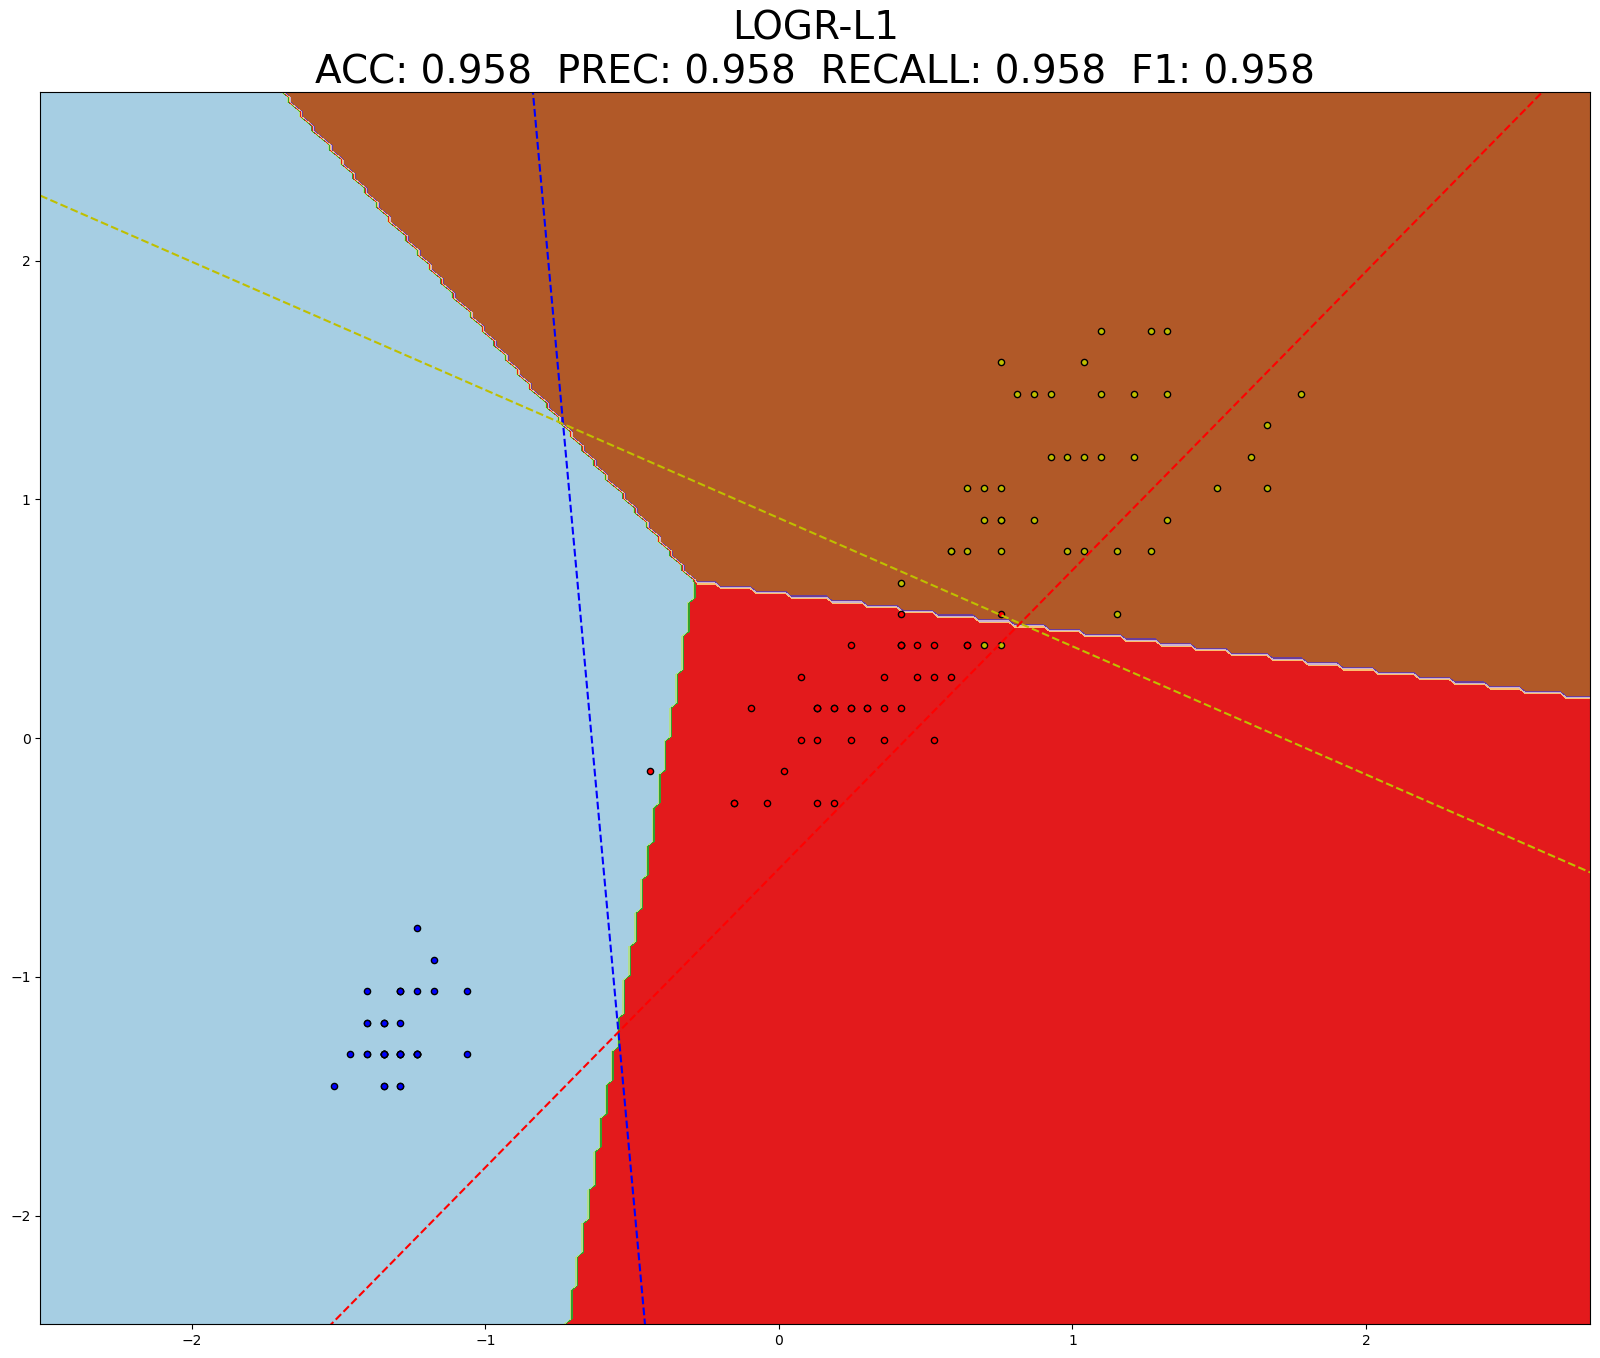

In [127]:
# 5.2) Entrenamiento del modelo definitivo
model = algoritmos['LOGR-L1'].fit(X_stdr, y_training)
print(model)

# Visualización de las fronteras de decisión
mapa_modelo_clasif_2d(X_stdr, y_training, model, results,'LOGR-L1')


In [128]:
# ------------- PREDICTION ---------------- #

In [129]:
# 6) Extracción de las características de test

In [130]:
# 7) Estandarización de las característiacs de test
X_test_stdr = standardizer.transform(X_testing)

In [131]:
# 8) Selección de los atributos de test 

In [132]:
# 9) Predicción del conjunto de test
y_pred_test = model.predict(X_test_stdr)
print(y_pred_test)

[0 2 1 1 0 1 0 0 2 1 2 2 2 1 0 0 0 1 1 2 0 2 1 1 2 2 1 0 2 0]


In [133]:
# 10) Evaluación del modelo sobre el conjunto de test
results = evaluacion(y_testing, y_pred_test, metricas)
print(results)
print(metrics.confusion_matrix(y_testing, y_pred_test))

{'ACC': 0.9333333333333333, 'PREC': 0.9333333333333333, 'RECALL': 0.9333333333333333, 'F1': 0.9333333333333333}
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


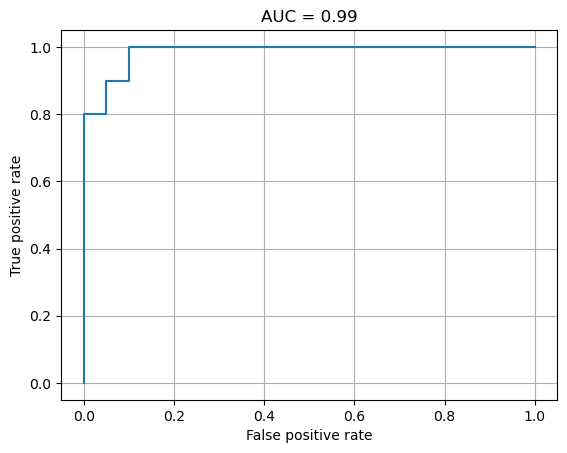

In [134]:
# Ploteamos la curva ROC
y_proba_test = model.predict_proba(X_test_stdr) # "predict_proba" para extraer probabilidades vez de predicciones

y_test_bin = preprocessing.label_binarize(y_testing, classes=[0,1,2]) # Usar "label_binarize" en el caso de problemas multiclase

auc = metrics.roc_auc_score(y_testing, y_proba_test, multi_class='ovr') # Area Under the ROC curve (AUC)

fpr, tpr, th = metrics.roc_curve(y_test_bin[:,1], y_proba_test[:,1])

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid()
plt.show()

In [135]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'DT': {'positive': (True, False)},
              'ADA_BOOST': {'alpha': (0.1, 1, 5, 10, 50, 100)},
              'RF': {'alpha': (0.1, 1, 5, 10, 50, 100)},
              'RANSAC': {'base_estimator':([linear_model.LinearRegression(),tree.DecisionTreeRegressor(),ensemble.RandomForestRegressor()]),
                         'min_samples':([2, 3, 5]),
                         'residual_threshold':(0.5,1,1.5),
                        'max_trials':([4,5,6]),
                         'loss':(['absolute_error'])},
              'KNN': {'n_neighbors':range(2,7),
                      'weights':('uniform', 'distance'),
                      'metric': ('minkowski', 'euclidean', 'manhattan')
                      
algs = {'DT': linear_model.LinearRegression(),
        'ADA_BOOST': linear_model.Lasso(random_state=42),
        'RF': linear_model.Ridge(random_state=42),
        'RANSAC': linear_model.RANSACRegressor(),
        'KNN': KNeighborsRegressor(),
        }                      